In [394]:
import skimage
import numpy as np

from glob import glob as show_dir_files
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from sklearn.metrics import pairwise_distances_argmin
from skimage import filters, measure, morphology, exposure, feature
import statistics
import cv2

In [395]:
from commons import (auto_invert_image_mask,
                     binarize_image,
                     find_bighest_cluster,
                     find_bighest_cluster_area,
                     find_roi, 
                     load_images_from_directory,
                     load_images_from_directory_resize,
                     check_colision_border,
                     plot)

In [418]:
def apply_k_means(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    image_array_sample = shuffle(image_array, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)

    return kmeans.cluster_centers_[labels].reshape(w, h, -1)

def apply_k_random(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
   
    labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)

    return codebook_random[labels_random].reshape(w, h, -1)


def apply_k_kmeans_gray(image, n_colors=3):
    
    k_means = KMeans(n_colors)
    k_means.fit(image.reshape((-1, 1)))
   
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    image_compressed = np.choose(labels, values)
    image_compressed.shape = image.shape
    
    return image_compressed

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def rescale_img(img):
    return (img * 255).astype('uint8')

def make_mask(image):
    def apply_thresh(image, block_size=1, thresh_type=199):
        return cv2.adaptiveThreshold(image, 
                                     1,
                                     cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 
                                     thresh_type,
                                     block_size).astype(bool)

    mask = apply_thresh(image, 1)
    
    mask = find_bighest_cluster(mask)
    
    mask = auto_invert_image_mask(mask)
    
    mask = morphology.closing(mask, morphology.disk(5))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=1)

    return binarize_image(mask)

In [408]:
all_images = show_dir_files('data/images/*')

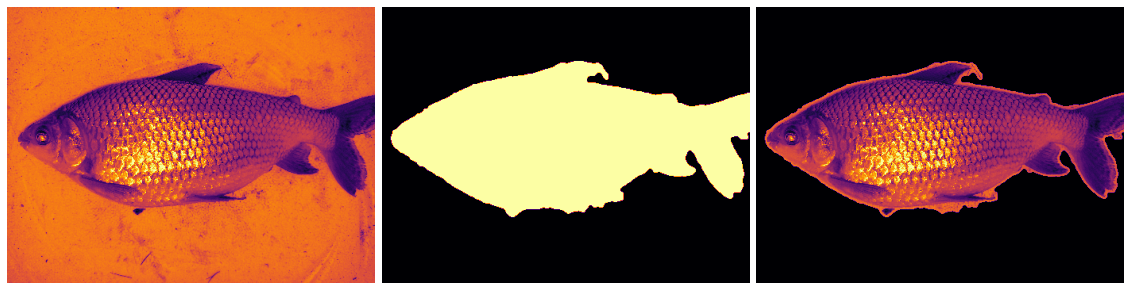

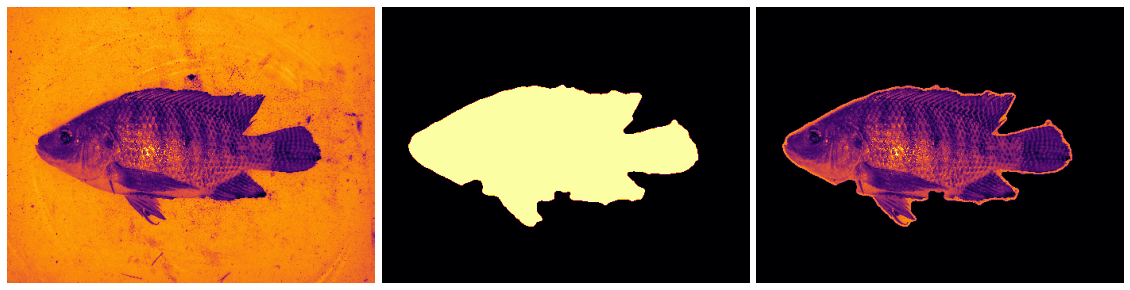

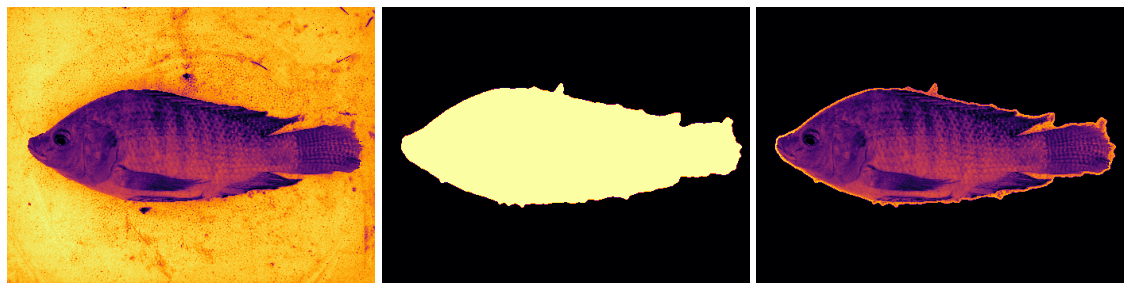

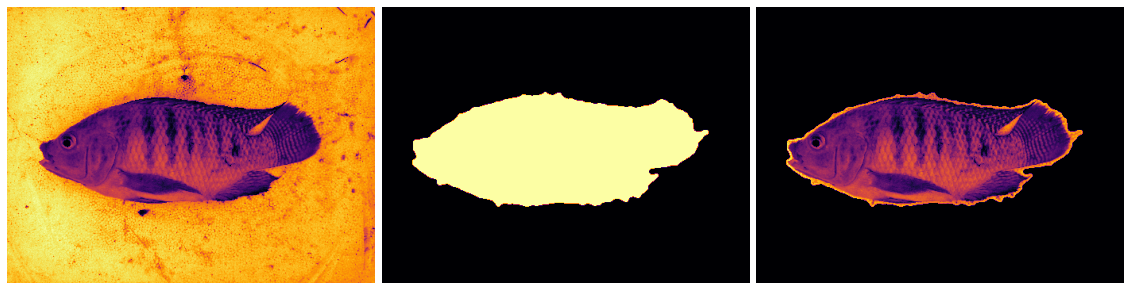

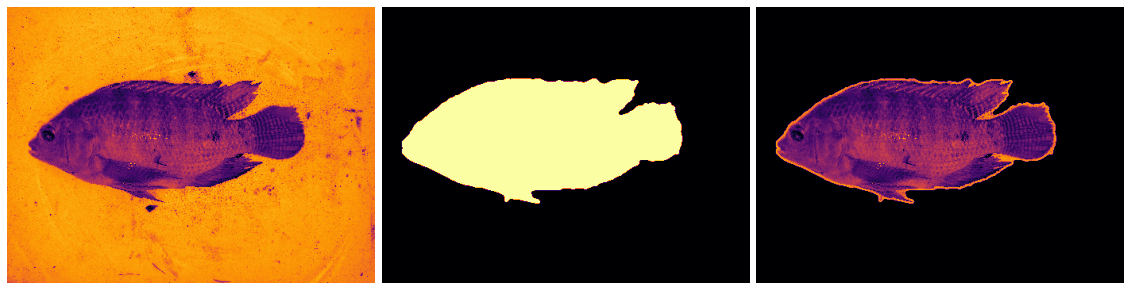

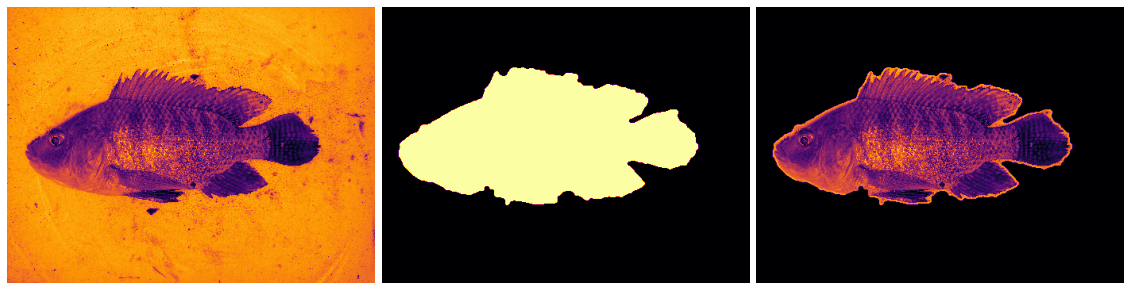

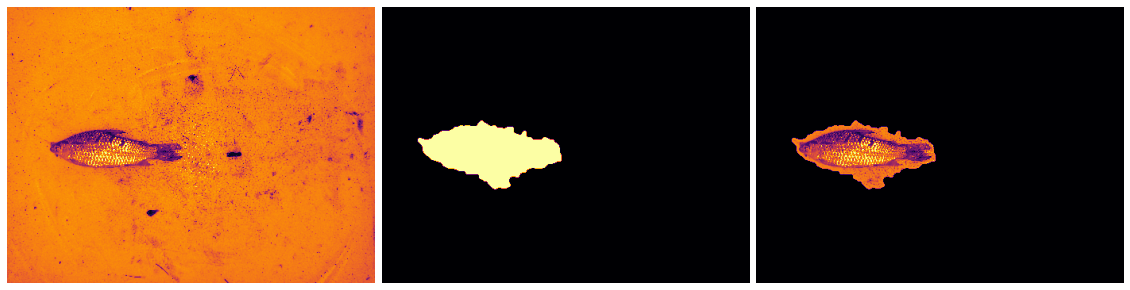

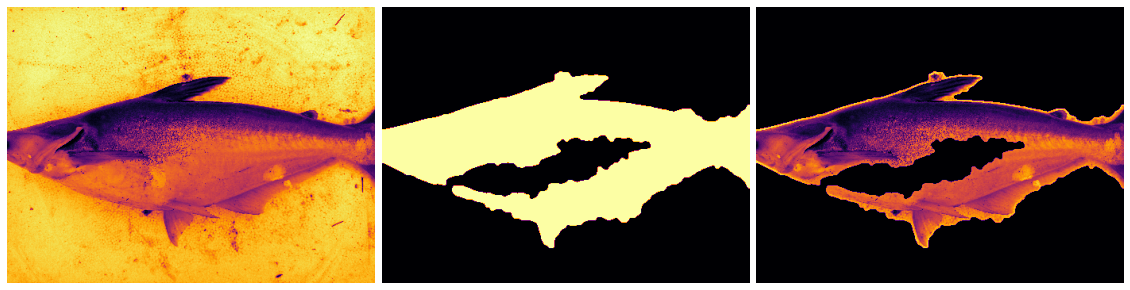

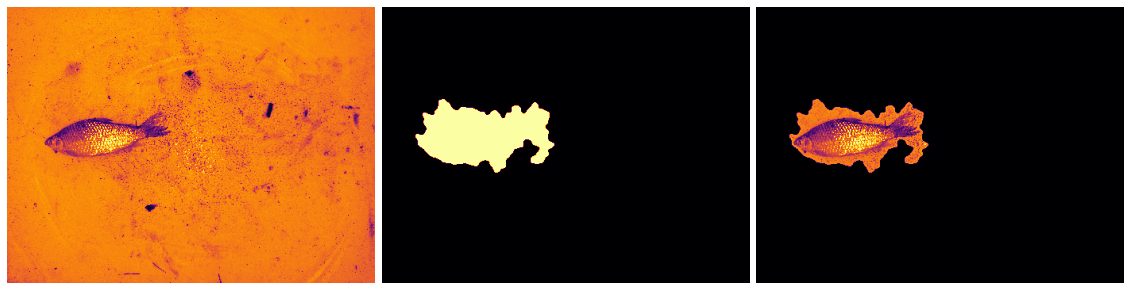

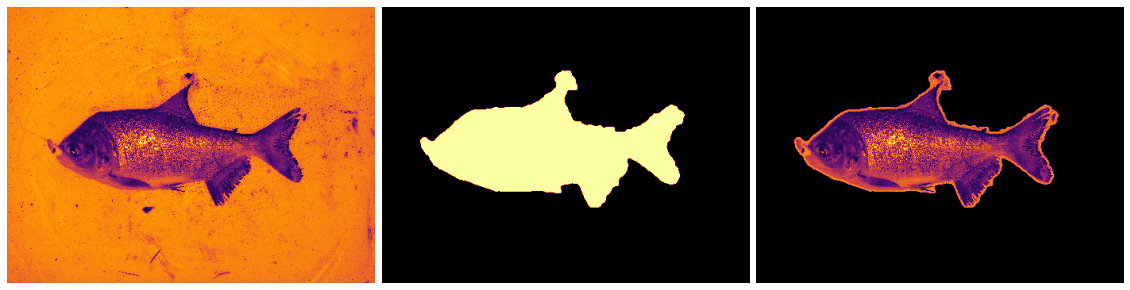

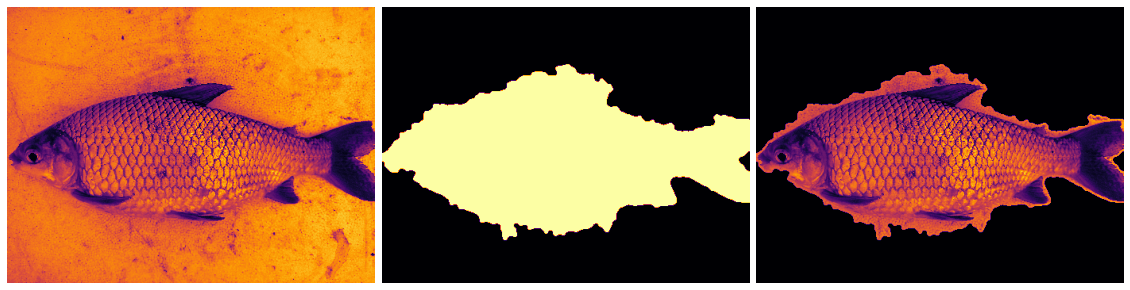

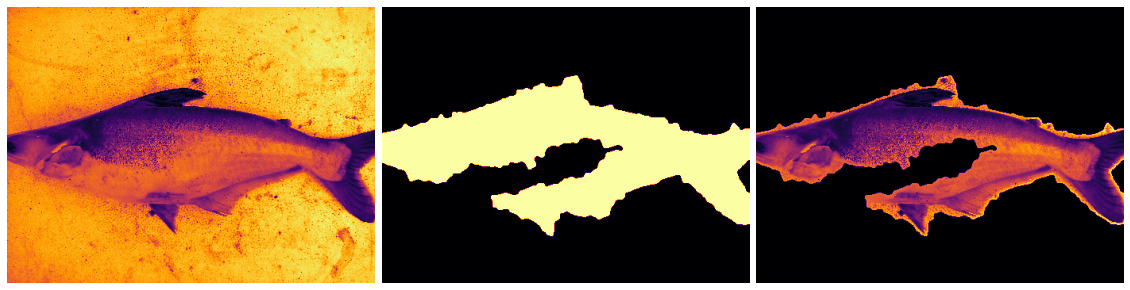

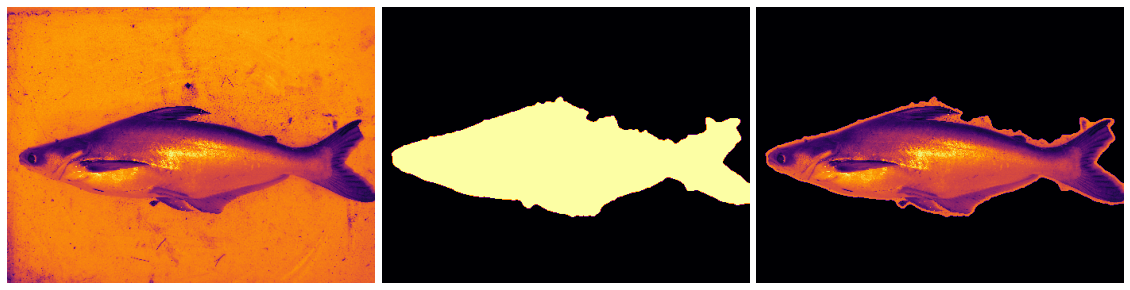

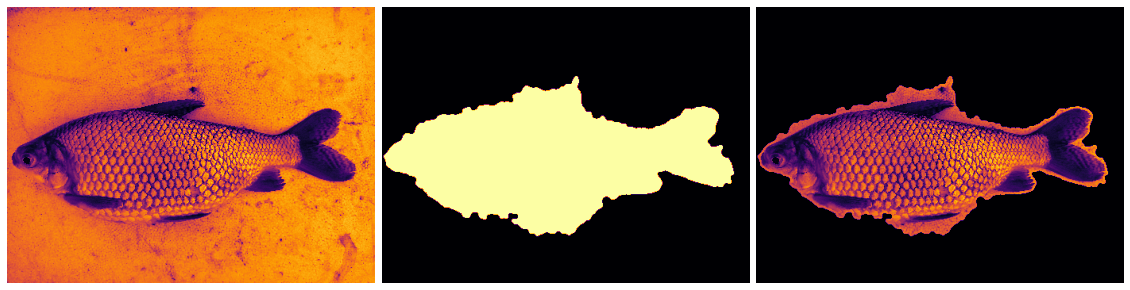

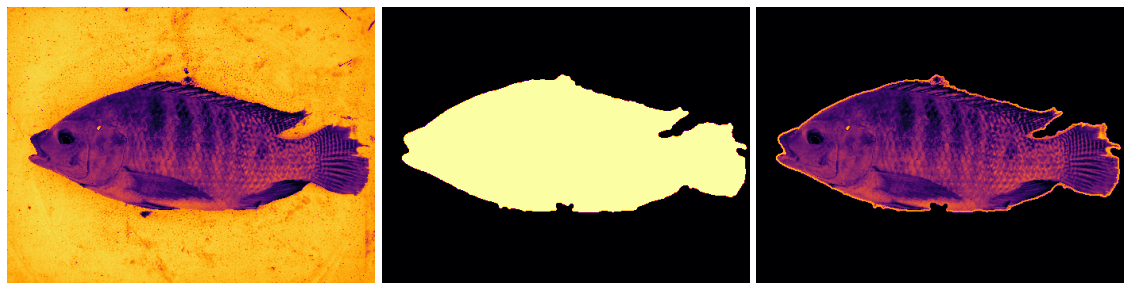

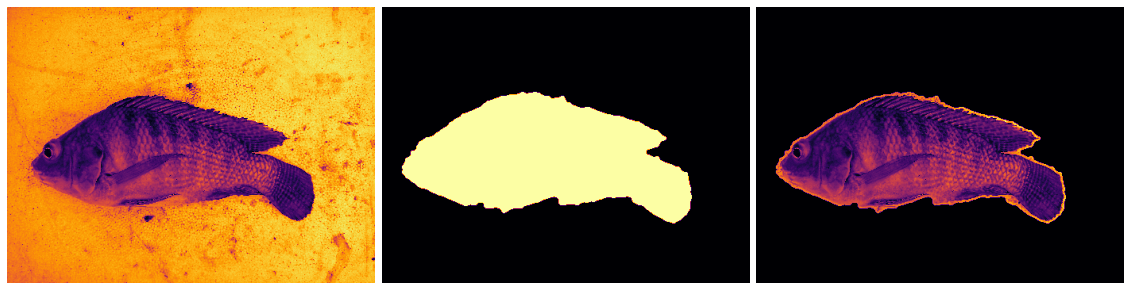

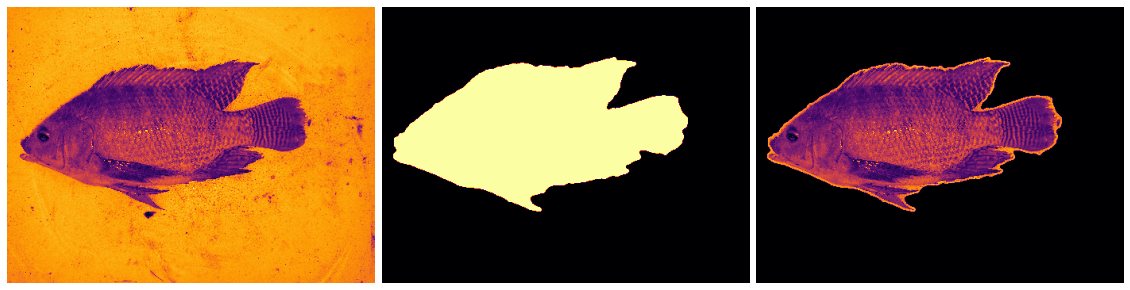

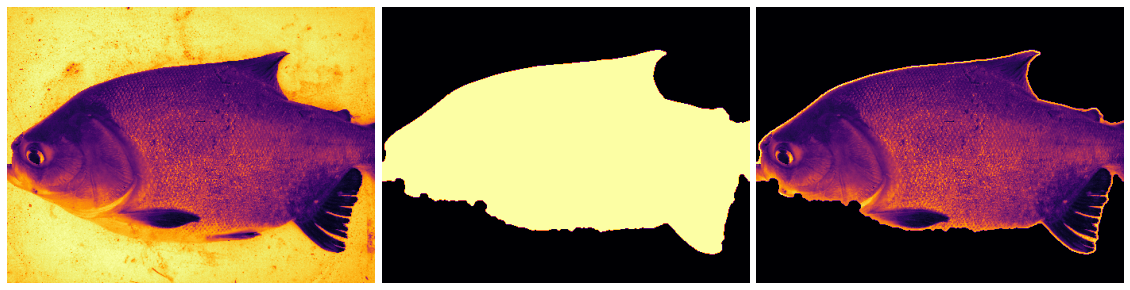

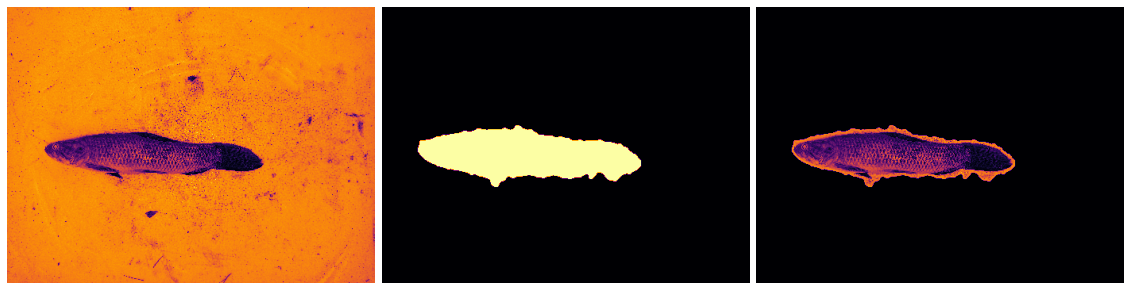

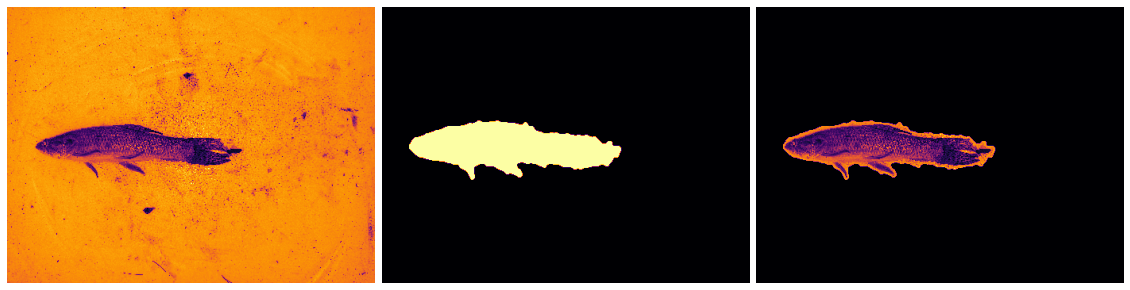

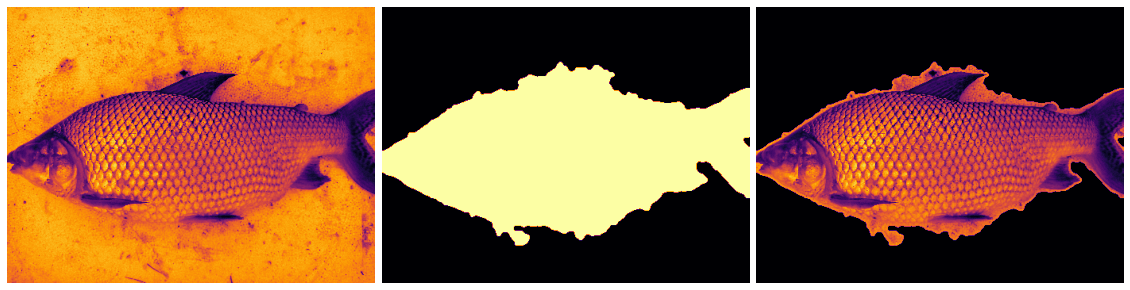

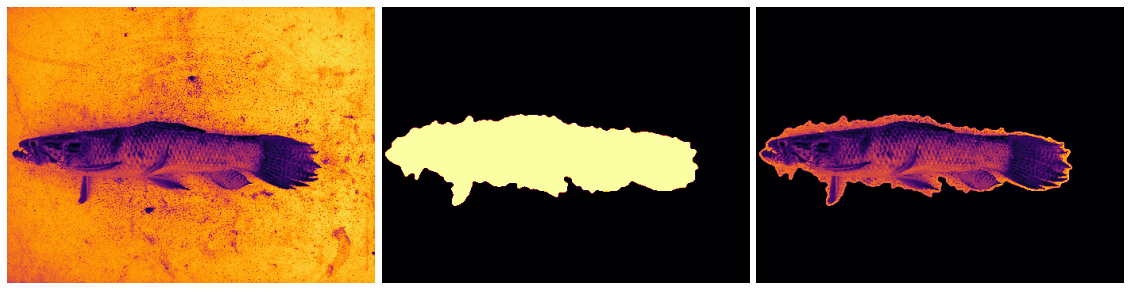

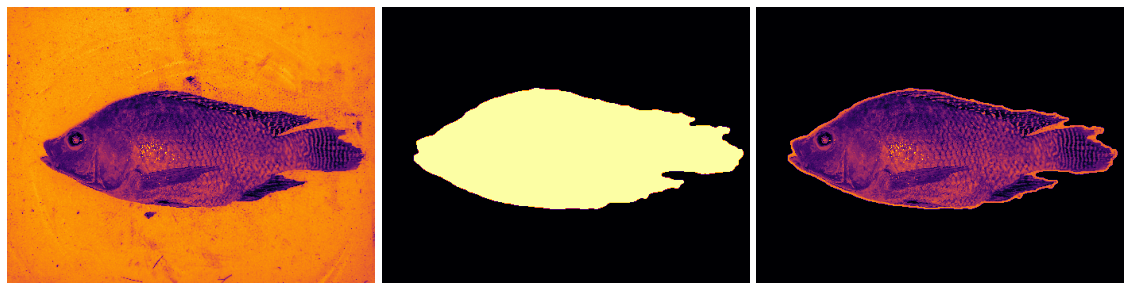

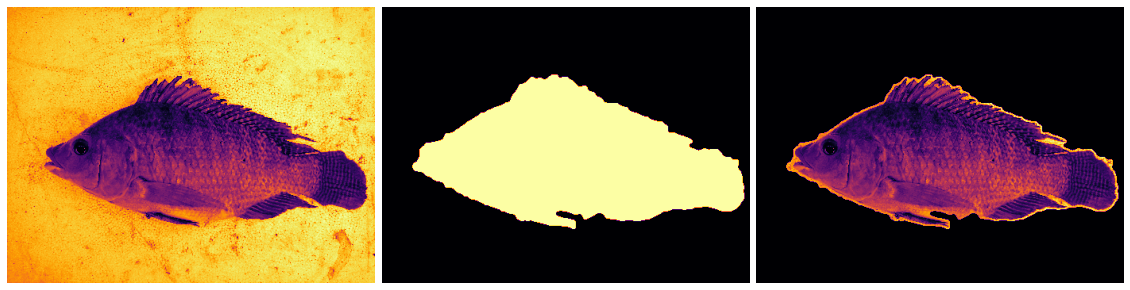

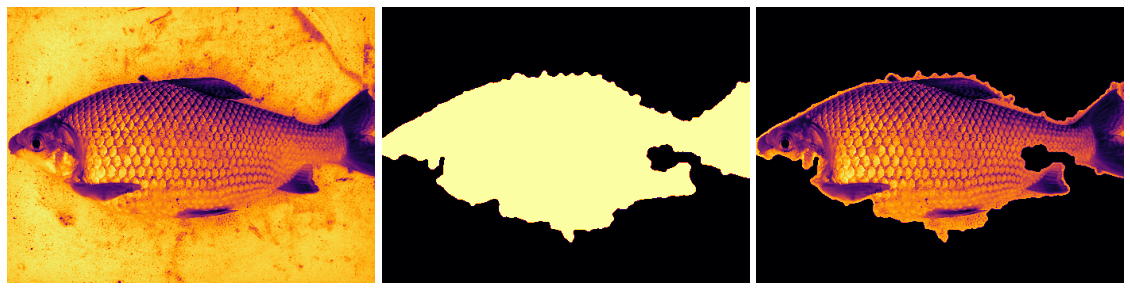

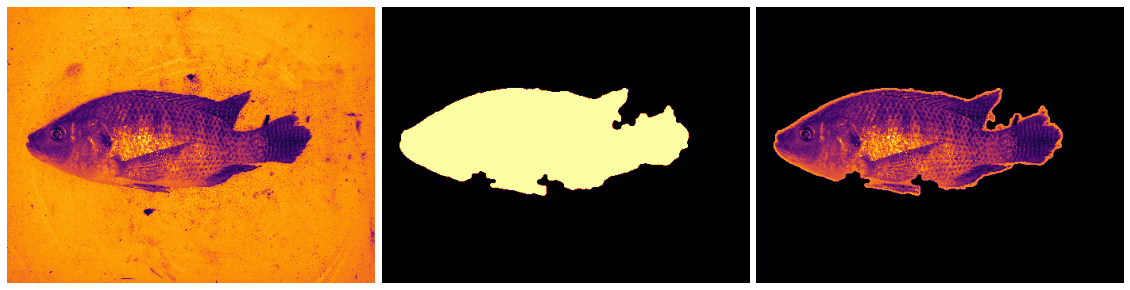

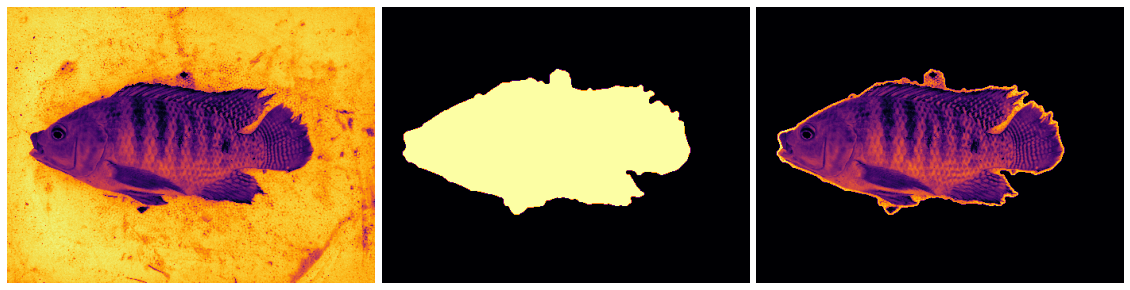

In [416]:
for path in all_images:
    image = (rgb2gray(normalize_image(imread(path)[::10, ::10]))  * 255).astype("uint8")
    
    result = make_mask(image)
    
    plot([image, result, (image * result)], (1, 3))